In [112]:
## Import lib for extracting training set from pdfs
import extract
import importlib
importlib.reload(extract)
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [4]:
#  Extract training set
train_indicies = extract.extract_words()

In [5]:
# Read training files as one string
smr_content = open('sum_train.txt', 'r').read()
xprnc_content = open('exp_train.txt', 'r').read()
edct_content = open('edu_train.txt', 'r').read()

In [6]:
def string_list(s_term, s_str):
    result = []
    crnt_ptr = s_str.find(s_term) + len(s_term)
    scd_term_index=s_str.find(s_term, crnt_ptr)
    while (scd_term_index>=0):
        # count only significantly long segments (>9 characters)
        if (scd_term_index-crnt_ptr>9):
            result.append(s_term + ' ' + s_str[crnt_ptr:scd_term_index])
        crnt_ptr = scd_term_index + len(s_term)
        scd_term_index=s_str.find(s_term, crnt_ptr)
    return result

In [7]:
# Put segment from each CV into separate string in an array
sum_list = string_list("Summary", smr_content)
xprnc_list = string_list("Experience", xprnc_content)
edctn_list = string_list("Education", edct_content)

##
(jan(uary|\.|)|feb(ruary|\.|)|mar(ch|\.|)|apr(il|\.|)|may(\.|)|jun(e|\.|)|jul(y|\.|)|aug(ust|\.|)|sep(tember|\.|)|oct(ober|\.|)|nov(ember|\.|)|dec(ember|\.|))\s+\d\d*

In [8]:
# Function for extracting vocabulary specific for a segment
import re
from nltk.stem.snowball import SnowballStemmer
def create_dictionary(topic_list):
    month_expr = re.compile(r"(jan(uary|\.|)|feb(ruary|\.|)|mar(ch|\.|)|apr(il|\.|)|may(\.|)|jun(e|\.|)|jul(y|\.|)|aug(ust|\.|)|sep(tember|\.|)|oct(ober|\.|)|nov(ember|\.|)|dec(ember|\.|))")
    year_expr = re.compile(r"((19|20)\d\d|'?\d\d)")
    result = dict()
    stemmer = SnowballStemmer('english')
    for string in topic_list:
        a = re.split('[^0-9A-Za-z]', string)
        a=list(filter(lambda x: x!='', a))
        for i in range(len(a)):
            a[i] = a[i].casefold()
            if re.fullmatch(year_expr, a[i]):
                a[i] = '!year'
            elif re.fullmatch(month_expr, a[i]):
                a[i] = '!month'
            else:
                a[i] = stemmer.stem(a[i])
            if (a[i] in result):
                result[a[i]] += 1
            else:
                result[a[i]] = 1
                
    return result


In [9]:
# Extract vocabulary specific for a segment
sum_dct = create_dictionary(sum_list)
xprnc_dct = create_dictionary(xprnc_list)
edctn_dct = create_dictionary(edctn_list)

In [10]:
# Functions for calculating term frequencies and corpus dictionary creation
def concat_dct(d1, d2):
    d3 = dict(d1)
    for key in d2.keys():
        if (key in d3):
            d3[key] += d2[key]
        else:
            d3[key] = d2[key]
    return d3

def sumDictValues(dctnr):
    N = 0
    for val in dctnr.values():
        N = + N + val
    return N

def calc_probs(dctnr):
    prob_dctnr = dict()
    tot_size = sumDictValues(dctnr)
    for key in dctnr.keys():
        prob_dctnr[key] = dctnr[key]/tot_size
    return prob_dctnr

In [11]:
# Uniting into corpus dictionary
new_dict = concat_dct(xprnc_dct, edctn_dct)
whole_dict = concat_dct(new_dict, sum_dct)

In [12]:
# Calculating probabilities
sum_prb = calc_probs(sum_dct)
xprnc_prb = calc_probs(xprnc_dct)
edctn_prb = calc_probs(edctn_dct)
whole_dict_prb = calc_probs(whole_dict)

In [13]:
# Test data generation
smr_test_content = open('sum_test.txt', 'r').read()
exp_test_content = open('exp_test.txt', 'r').read()
edu_test_content = open('edu_test.txt', 'r').read()

In [241]:
def replace_with_space(matchobj):
    return " "

def construct_marked_set(new_content):
    CRIT_LENGTH_LIMIT = 100
    result = np.zeros(4).reshape(1,4)
#    rep_pattern = re.compile(r"((Summary|Experience|Education)|[^A-Za-z0-9\s])")
    rep_pattern = re.compile(r"([^A-Za-z0-9\s])")
    category = 1
    for string in new_content:
        a = re.sub(rep_pattern, replace_with_space, string)
        cumulative_str = ''
        for substr in a.split('\n'):
            cumulative_str += substr + ' '
            if(len(cumulative_str) > CRIT_LENGTH_LIMIT):
                result = np.append(result, np.asarray([cumulative_str, category, 0, -300000.0]).reshape(1,4), axis=0)
                cumulative_str = ''
        if(len(cumulative_str) > 2):
                result = np.append(result, np.asarray([cumulative_str, category, 0, -300000.0]).reshape(1,4), axis=0)
        category += 1
    return result[1:]

In [242]:
test_set = construct_marked_set([smr_test_content, edu_test_content, exp_test_content])

In [178]:
import math as m
from nltk.stem.snowball import SnowballStemmer
def calculate_likelihood(string, dct, corp_dct, prb_segment):
    stemmer = SnowballStemmer('english')
    month_expr = re.compile(r"(jan(uary|\.|)|feb(ruary|\.|)|mar(ch|\.|)|apr(il|\.|)|may(\.|)|jun(e|\.|)|jul(y|\.|)|aug(ust|\.|)|sep(tember|\.|)|oct(ober|\.|)|nov(ember|\.|)|dec(ember|\.|))")
    year_expr = re.compile(r"((19|20)\d\d|'?\d\d)")
    num = 1.0
    den = 1.0
    result = .0
    for word in string.split():
        wrd = word.casefold()
        if re.fullmatch(year_expr, wrd):
            wrd = '!year'
        elif re.fullmatch(month_expr, wrd):
            wrd = '!month'
        else:
             wrd = stemmer.stem(wrd)
        #print(wrd)
        if wrd in dct:# and wrd in corp_dct:
            num *= dct[wrd]
            den *= corp_dct[wrd]
            result += m.log2(prb_segment*num/den)
        else:
            result += m.log2(1e-300)
    #print(num)
    #print(den)
    return result
    
def test_algorithm(test_set, dictionaries, corpus_dict):
    local_test_set = test_set.copy()
    #likelihoods = np.zeros(len(dictionaries))
    prb_corpus = calc_probs(corpus_dict)
    i=0
    for a_dict in dictionaries:
        prb_segment = sumDictValues(a_dict) / sumDictValues(corpus_dict)
        print('Segment ' + repr(i+1) + ' portion in the dictionary ' + repr(prb_segment))
        prb_dict = calc_probs(a_dict)
        for line in local_test_set:
#                print('new_like')
#                print(line[0] + "ttteeest")
            likelihood = calculate_likelihood(line[0], prb_dict, prb_corpus, prb_segment)
            if likelihood > np.float(line[3]):
                line[3] = likelihood
                line[2] = i+1
        i+=1
    prc, recall, f_one_score = quality_assessment(local_test_set[:,1], local_test_set[:,2], 3)
    return f_one_score

In [65]:
f1_score = test_algorithm(test_set, [sum_dct, edctn_dct, xprnc_dct], whole_dict)
print(f1_score)

Segment 1 portion in the dictionary 0.17029628434693767
Segment 2 portion in the dictionary 0.14201215249771468
Segment 3 portion in the dictionary 0.6876915631553476
precision = 0.908257
recall = 0.75572519084
F1-score = 0.825
0.825


In [305]:
# precision, recall, F1-score
def quality_assessment(a, b, ctgr):
    b_correct = ((a.astype(int) == b.astype(int)) * a.astype(int)==ctgr).sum()
    b_attempts = ((b.astype(int) == ctgr)).sum()
    a_total = ((a.astype(int) == ctgr)).sum()
    if b_attempts == 0:
        return 0, 0, 0
    prec = b_correct/b_attempts
    rcll = b_correct/a_total
    f_one = 2*prec*rcll/(prec+rcll)
#    print ('precision = %f' %prec)
#    print ('recall =', rcll)
#    print ('F1-score =', f_one)
    return prec, rcll, f_one

In [19]:
# summary identification assessment
quality_assessment(test_set[:,1], test_set[:,2], 1)

precision = 0.409091
recall = 0.5625
F1-score = 0.473684210526


(0.40909090909090912, 0.5625, 0.47368421052631576)

In [20]:
# education identification assessment
quality_assessment(test_set[:,1], test_set[:,2], 2)

precision = 0.772727
recall = 1.0
F1-score = 0.871794871795


(0.77272727272727271, 1.0, 0.87179487179487181)

In [57]:
# experience identification assessment
quality_assessment(test_set[:,1], test_set[:,2], 3)

precision = nan
recall = 0.0
F1-score = nan


(nan, 0.0, nan)

In [22]:
print(confusion_matrix(test_set[:,1], test_set[:,2]))

[[18  4 10]
 [ 0 34  0]
 [26  6 99]]


In [23]:
# Extract test set from 'other' folder
file_number_in_folder=6
extract.extract_other_pdfs(file_number_in_folder)

In [24]:
# Test data generation
other_test_content = open('test_other.txt', 'r').read()

In [169]:
# Head of selected CV
other_test_content[:100]

'Stefan Petranek  78 Vermont Street Rochester, NY 14609     spetrane@yahoo\n.com     (585) 256 0296   '

In [53]:
test_set_other = construct_marked_set([other_test_content])

In [54]:
test_algorithm(test_set_other, [sum_dct, edctn_dct, xprnc_dct], whole_dict)

Segment 1 portion in the dictionary 0.17029628434693767


ValueError: math domain error

In [172]:
def print_recognition_results(test_set):
    category=''
    for line in test_set:
        if line[2] == '1':
            category = 'Summary'
        elif line[2] == '2':
            category = 'Education'
        else:
            category = 'Experience'
        print(line[0][:50] + '...\t\t' + category)

In [320]:
def jelin_merc_smoothing(segm_dict, corpus_dict, lmbd):
    result_dct = segm_dict.copy()
    for key in corpus_dict.keys():
        if key in segm_dict:
            result_dct[key] = (1-lmbd)*segm_dict[key] + lmbd*corpus_dict[key]
        else:
            result_dct[key] = lmbd*corpus_dict[key]
    return result_dct

def dirichlet_smoothing(segm_dict, corpus_dict, mu):
    result_dct = segm_dict.copy()
    d = len(segm_dict.keys())
    for key in corpus_dict.keys():
        if key in segm_dict:
            result_dct[key] = d/(d+mu)*segm_dict[key] + mu/(d+mu)*corpus_dict[key]
        else:
            result_dct[key] = mu/(d+mu)*corpus_dict[key]
    return result_dct

In [321]:
def test_algorithm_w_smoothing(test_set, dictionaries, corpus_dict, param):
    #likelihoods = np.zeros(len(dictionaries))
    local_test_set = test_set.copy()
    prb_corpus = calc_probs(corpus_dict)
    i=0
    for a_dict in dictionaries:
        prb_segment = sumDictValues(a_dict) / sumDictValues(corpus_dict)
#        print('Segment ' + repr(i+1) + ' portion in the dictionary ' + repr(prb_segment))
        prb_dict = calc_probs(a_dict)
        prb_smoothed = dirichlet_smoothing(prb_dict, prb_corpus, param)
        for line in local_test_set:
#                print('new_like')
#                print(line[0] + "ttteeest")
            likelihood = calculate_likelihood(line[0], prb_smoothed, prb_corpus, prb_segment)
            if likelihood > np.float(line[3]):
                line[3] = likelihood
                line[2] = i+1
        i+=1
    F1_score_array = np.array([])
    F1_score_array = np.append(F1_score_array, quality_assessment(local_test_set[:,1], local_test_set[:,2], 1)[2])
    F1_score_array = np.append(F1_score_array, quality_assessment(local_test_set[:,1], local_test_set[:,2], 2)[2])
    F1_score_array = np.append(F1_score_array, quality_assessment(local_test_set[:,1], local_test_set[:,2], 3)[2])
    f_one_score = np.mean(F1_score_array)
    return f_one_score

In [327]:
f1_score = test_algorithm_w_smoothing(test_set, [sum_dct, edctn_dct, xprnc_dct], whole_dict, 1)
print(f1_score)

0.690924775707


In [316]:
def analyze_lmbd(test_set, dictionaries, corpus_dict):
    lmbd_arr = np.linspace(0,1,10)
    lmbd_arr[0] = 1e-10
    f_score_arr = np.zeros(lmbd_arr.size)
    for i in range(len(lmbd_arr)):
        f_score_arr[i] = test_algorithm_w_smoothing(test_set, dictionaries, corpus_dict, lmbd_arr[i])
    print('F1-score array: {}'.format(f_score_arr))
    return lmbd_arr, f_score_arr

In [318]:
lambdas, f_scores = analyze_lmbd(test_set, [sum_dct, edctn_dct, xprnc_dct], whole_dict)

F1-score array: [ 0.65236876  0.7539099   0.7461145   0.7461145   0.75590829  0.74858328
  0.74444032  0.76334     0.64864468  0.26626016]


In [137]:
lambdas[9]

1.0

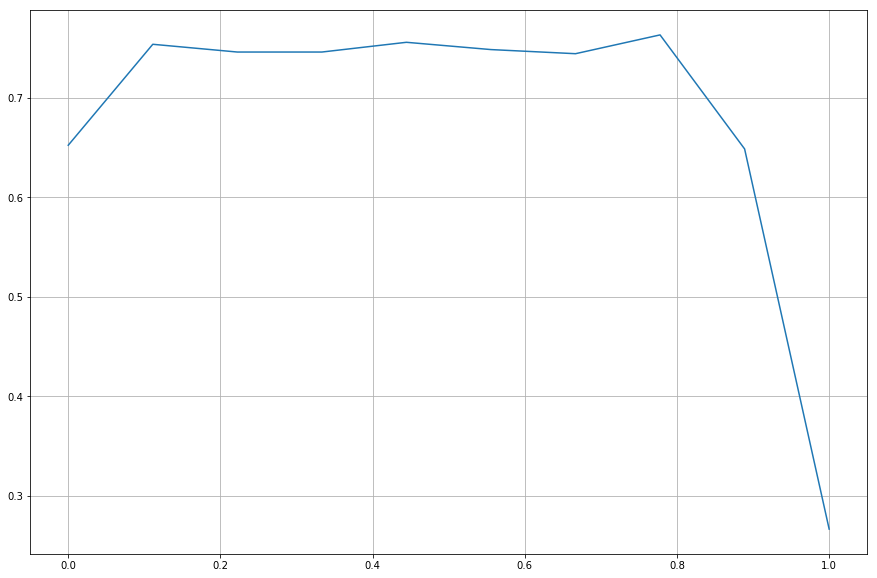

In [319]:
fig = plt.figure(figsize=[15,10])
plt.plot(lambdas, f_scores)
plt.grid()
plt.show()

In [336]:
def analyze_mu(test_set, dictionaries, corpus_dict):
    mu_arr = np.geomspace(1,10000,num=10)
    f_score_arr = np.zeros(mu_arr.size)
    for i in range(len(mu_arr)):
        f_score_arr[i] = test_algorithm_w_smoothing(test_set, dictionaries, corpus_dict, mu_arr[i])
    print('F1-score array: {}'.format(f_score_arr))
    return mu_arr, f_score_arr

In [335]:
np.geomspace(1,10000,num=10)

array([  1.00000000e+00,   2.78255940e+00,   7.74263683e+00,
         2.15443469e+01,   5.99484250e+01,   1.66810054e+02,
         4.64158883e+02,   1.29154967e+03,   3.59381366e+03,
         1.00000000e+04])

In [337]:
mus, f_scores = analyze_mu(test_set, [sum_dct, edctn_dct, xprnc_dct], whole_dict)

F1-score array: [ 0.69092478  0.71069902  0.72378977  0.74653641  0.73886215  0.75673768
  0.75089699  0.75420244  0.74202745  0.57095719]


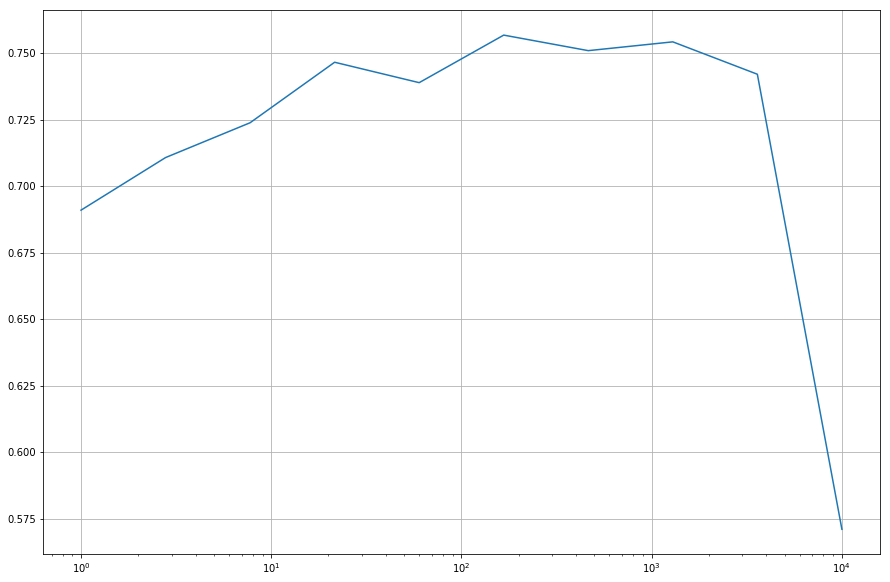

In [350]:
from matplotlib.axes import Axes
fig = plt.figure(figsize=[15,10])
plt.semilogx()
plt.plot(mus, f_scores)
plt.grid()
plt.show()

In [338]:
mus

array([  1.00000000e+00,   2.78255940e+00,   7.74263683e+00,
         2.15443469e+01,   5.99484250e+01,   1.66810054e+02,
         4.64158883e+02,   1.29154967e+03,   3.59381366e+03,
         1.00000000e+04])